In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2 as cv
import numpy as np
from utils.io_utils import get_images, get_matching_pairs, save_extrinsics_calib
from utils.calib_utils import detect_keypoints
from utils.vis_utils import plot_figures, plot_epipolar_lines, normalize_image, draw_chessboard_corners
from utils.common_utils import filter_orientation, prepare_calib_input

WARNING - 2021-03-24 18:20:17,580 - core - In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
WARNING - 2021-03-24 18:20:17,590 - core - In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
WARNING - 2021-03-24 18:20:17,591 - core - In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
WARNING - 2021-03-24 18:20:17,592 - core - In /home/konstantin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
T

### Load images

In [62]:
# Be careful with the extension
img_ext = '.jpg'

In [63]:
data_path1 = "/home/konstantin/datasets/bandeja-sequence/2020-11-17-18-52-32-chess/camera0"
data_path2 = "/home/konstantin/datasets/bandeja-sequence/2020-11-17-18-52-32-chess/camera1"

In [64]:
# Deterime matching pairs using timestamps or if they are not in sync then you have to provide pairs manually
timestamps1, timestamps2 = get_matching_pairs(data_path1, data_path2)

In [65]:
images1 = get_images(data_path1, period=4, file_name_list=[fn + img_ext for fn in timestamps1])
images2 = get_images(data_path2, period=4, file_name_list=[fn + img_ext for fn in timestamps2])

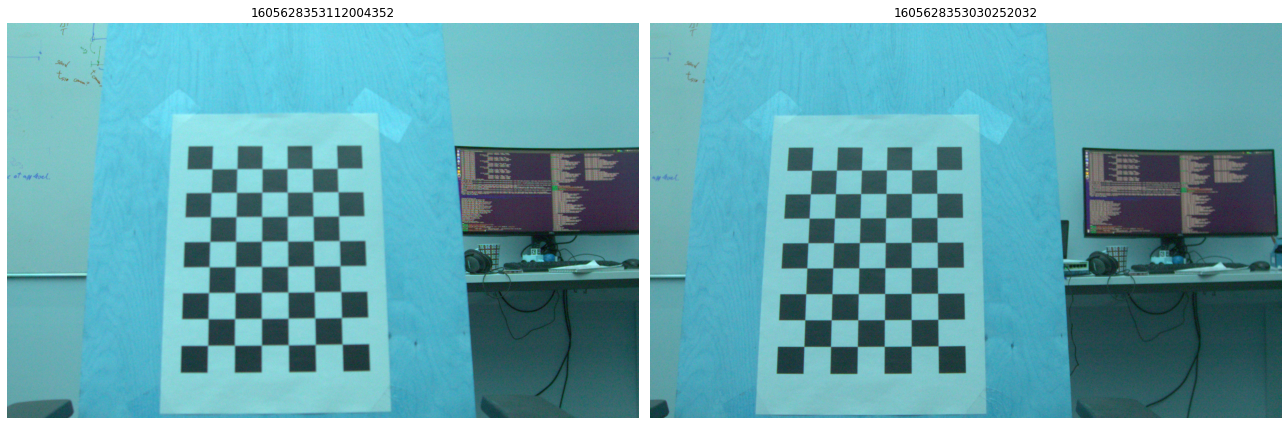

In [66]:
idx = 0

check_key1, check_key2 = timestamps1[idx], timestamps2[idx]

plot_figures({check_key1: normalize_image(images1[check_key1 + img_ext]), 
              check_key2: images2[check_key2 + img_ext]}, 1, 2)

### Detect keypoints

In [67]:
pattern_size = (8, 6)
edge_length = 0.055

In [68]:
detections1 = detect_keypoints(images1, pattern_size, edge_length)
detections2 = detect_keypoints(images2, pattern_size, edge_length)

In [69]:
# Leave only those  pairs that have detections on both images
det_mask1 = np.array([t + img_ext in detections1 for t in timestamps1])
det_mask2 = np.array([t + img_ext in detections2 for t in timestamps2])

det_mask = det_mask1 & det_mask2

d_timestamps1, d_timestamps2 = timestamps1[det_mask], timestamps2[det_mask]

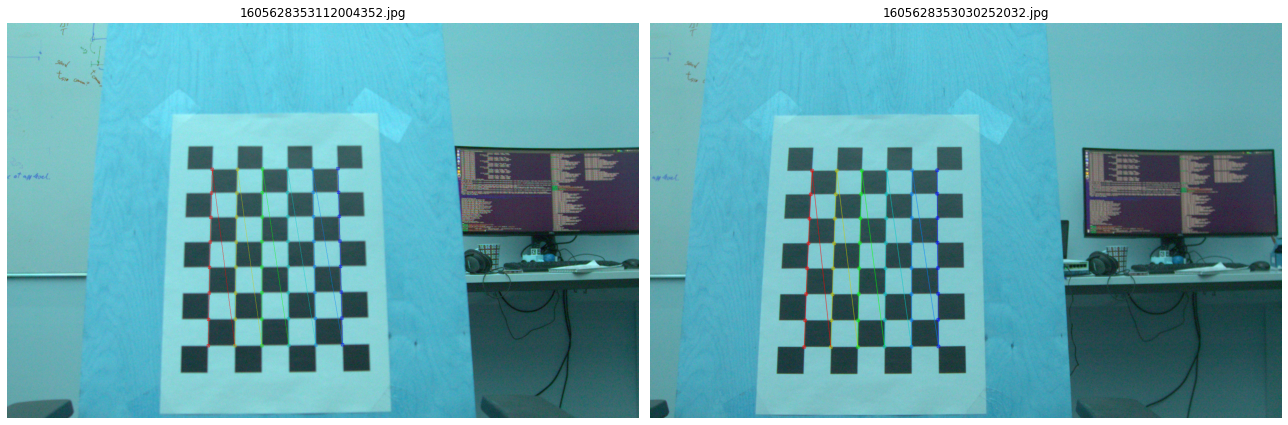

In [70]:
idx = 0

check_key1, check_key2 = d_timestamps1[idx] + img_ext, d_timestamps2[idx] + img_ext

plot_figures({check_key1: draw_chessboard_corners(images1[check_key1], detections1[check_key1][1], pattern_size, normalize=True),
              check_key2: draw_chessboard_corners(images2[check_key2], detections2[check_key2][1], pattern_size)}, 1, 2)


### Calibrate extrinsics

In [71]:
calib_intrinsics1 = np.load('calib_output/basler0_intrinsics.npy', allow_pickle=True).item()
calib_intrinsics2 = np.load('calib_output/basler1_intrinsics.npy', allow_pickle=True).item()

In [72]:
intrinsics1 = calib_intrinsics1['intrinsics']
dist_coeff1 = calib_intrinsics1['dist_coeff']

# Stock intrinsics for azure
# intrinsics1 = np.array([[503.9581604003906, 0.0, 325.4591064453125],
#                        [0.0, 504.0079345703125, 340.33404541015625],
#                        [0.0, 0.0, 1.0]])
# dist_coeff1 = np.array([5.268435478210449, 3.5621509552001953, -6.14773682627856e-07, -4.438921678229235e-05, 0.1832902431488037, 5.597447872161865, 5.32110071182251, 0.9697896838188171])

intrinsics2 = calib_intrinsics2['intrinsics']
dist_coeff2 = calib_intrinsics2['dist_coeff']

In [74]:
# Orientation of the detected pattern of different images may be different. Use one image as anchor and leave only 
# those that have the same orientation

criteria = (cv.TERM_CRITERIA_MAX_ITER + cv.TERM_CRITERIA_EPS, 100, 0.0001)

f_detections1, f_detections2 = filter_orientation(detections1, pattern_size, anchor_index=0), \
                                filter_orientation(detections2, pattern_size, anchor_index=0)


scene_points, loc_kp1, shape = prepare_calib_input(images1, detections1, d_timestamps1, ext=img_ext)
_, loc_kp2, _ = prepare_calib_input(images2, detections2, d_timestamps2, ext=img_ext)

In [75]:


reproj_error, _, _, _, _, R, t, E, F = cv.stereoCalibrate(scene_points, loc_kp1, loc_kp2, 
                                                          intrinsics1, dist_coeff1, 
                                                          intrinsics2, dist_coeff2,
                                                          shape, flags=cv.CALIB_FIX_INTRINSIC, criteria=criteria)

T = np.zeros((4, 4))
T[:3, :3] = R
T[:3, 3] = t.reshape(-1)
T[3, 3] = 1

print(reproj_error)

7.673725126399523


### Visualize calibration results

In [76]:
print("Final transformation:")
print(T)

Final transformation:
[[ 9.99940028e-01 -1.94732663e-03 -1.07772404e-02 -9.08710947e-02]
 [ 1.97076056e-03  9.99995716e-01  2.16419715e-03 -7.06846671e-04]
 [ 1.07729799e-02 -2.18530671e-03  9.99939582e-01 -5.27973950e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


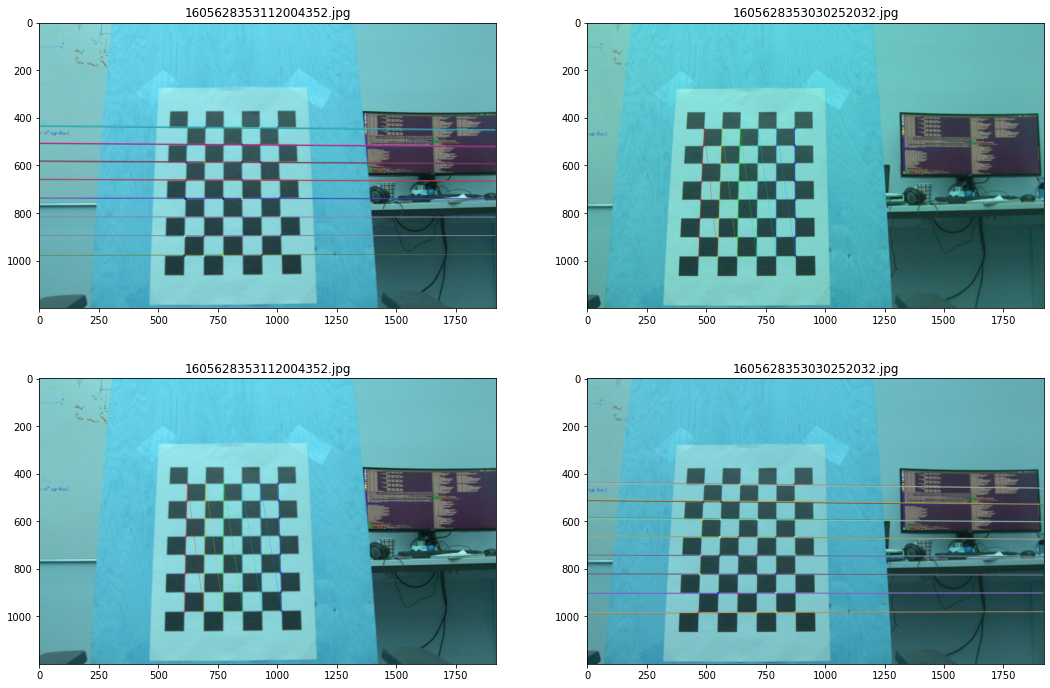

In [78]:
idx = 0

check_key1, check_key2 = d_timestamps1[idx] + img_ext, d_timestamps2[idx] + img_ext

plot_epipolar_lines(images1[check_key1], images2[check_key2],
                    detections1[check_key1][1], detections2[check_key2][1], 
                    check_key1, check_key2, F, pattern_size)

In [79]:
calib_name = 'basler02basler1'
save_extrinsics_calib(calib_name, T)

Saved calibration results as calib_output/basler02basler1_extrinsics.npy
